# Краткое описание проекта

Мне были представлены данные онлайн-школы. Их нужно было проверить на наличие аномалий, выполнить запросы от продукт-менеджера 
и построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию.

# Загрузка данных и библиотек

In [5]:
import pandas as pd
import requests
import urllib
import json
import seaborn as sns
from urllib.parse import urlencode
import requests
import matplotlib.pyplot as plt 

%matplotlib inline

Данные об оценках в тесте

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/PBW7aUHGuodFDA' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_asses = pd.read_csv(requests.get(final_url).json()['href'])

Список предметов по семестрам

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_courses = pd.read_csv(requests.get(final_url).json()['href'])

Результаты тестов студентов

In [8]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/lsmdbYB0iM7p3w' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_student_asses = pd.read_csv(requests.get(final_url).json()['href'])

Данные о регистрирации для прохождения курса в семестре

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/Yse4Y6RJqg_WaA' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_student_reg = pd.read_csv(requests.get(final_url).json()['href'])

# Задания

1.Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [10]:
#Соединяем данные результатов экзаменов студентов и сами предметы по номеру задания
student_tests =  df_asses.merge(df_student_asses, how = 'inner', on = 'id_assessment') 

In [11]:
exams = student_tests.query('assessment_type == "Exam"')

In [12]:
#Сортируем успешные 
exams_count = exams.query('score >= 40').groupby('id_student').agg({'code_module':'sum'})

In [13]:
exams_count = exams_count.code_module.value_counts()
exams_count

DDD       2411
CCC       1391
CCCDDD     292
DDDDDD       3
Name: code_module, dtype: int64

In [14]:
exams_count.DDD+exams_count.CCC 

3802

Ответ: 3802 студентов

---

2.Выяви самый сложный и самый простой экзамен: 
найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.
завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [15]:
#У нас уже есть отдельный дата-фрейм с экзаменами. 
exams 

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
52923,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
52924,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
52925,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
52926,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
52927,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
95980,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
95981,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
95982,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
95983,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


In [16]:
#Создаём колонку с зачётом и без.
exams.loc[exams['score'] < 40, 'success'] = 'failed' 
exams.loc[exams['score'] >= 40, 'success'] = 'passed'

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [17]:
exam_suc = exams.groupby(['code_module','success'], as_index = False ).agg({'id_student':'count'})

In [18]:
exam_suc

,code_module,success,id_student
0,CCC,failed,232
1,CCC,passed,1683
2,DDD,failed,335
3,DDD,passed,2709


In [19]:
exam_suc = exam_suc.pivot(index='code_module', columns='success', values='id_student')

In [20]:
exam_suc.passed / (exam_suc.failed + exam_suc.passed) 

code_module
CCC    0.878851
DDD    0.889947
dtype: float64

In [21]:
#Завершаемость в разрезе id_assessment.
exam_suc_2 = exams.groupby(['id_assessment','success'], as_index = False ).agg({'id_student':'count'})
exam_suc_2 = exam_suc_2.pivot(index='id_assessment', columns='success', values='id_student')
exam_suc_2.passed / (exam_suc_2.failed + exam_suc_2.passed)

id_assessment
24290    0.888889
24299    0.872432
25340    0.837209
25354    0.907025
25361    0.925573
25368    0.886316
dtype: float64

Ответ: на курсе DDD завершаемость выше курса ССС. То есть DDD самый высокий по завершаемости, а самый низкий ССС. Самый высокий по завершаемости экзамен - 25361, а самый низкий - 25340.

---

3. По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом).

In [22]:
d = exams.query('success == "passed"').groupby(['code_module', 'id_student'], as_index = False ).agg({'date_submitted':'count'})
#ищем тех, кто сдавал экзамен успешно, но 2 раза

In [23]:
d.query('date_submitted > 1')

,code_module,id_student,date_submitted
2591,DDD,540758,2
3181,DDD,593903,2
3339,DDD,605118,2


In [24]:
exams = exams.reset_index()

In [25]:
exams.query('id_student == 540758 or id_student == 593903 or id_student == 605118')

,index,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,success
2258,75235,DDD,2013B,25340,Exam,240.0,100.0,540758,229,0,40.0,passed
2786,82731,DDD,2013J,25354,Exam,261.0,100.0,593903,241,0,49.0,passed
2899,82844,DDD,2013J,25354,Exam,261.0,100.0,605118,237,0,42.0,passed
3610,87573,DDD,2014B,25361,Exam,241.0,100.0,540758,234,0,60.0,passed
4685,95711,DDD,2014J,25368,Exam,NaN,100.0,593903,243,0,44.0,passed
4723,95749,DDD,2014J,25368,Exam,NaN,100.0,605118,243,0,64.0,passed


In [26]:
exams_without_dub = exams.drop(exams.index[[2258,2786,2899]])
#удаляем тех, кто сдавал экзамен успешно, но 2 раза (получилось костылями, но получилось же?)

In [27]:
exams_without_dub.query('success == "passed"').groupby(['code_module'], as_index = False ).agg({'date_submitted':'mean'}) 

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.978566


Ответ: средний срок сдачи экзаменов  239 CCC, 238 DDD

---

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них.
А также предметы с самым большим оттоком (ТОП-3). 

In [28]:
top_pop = df_student_reg.groupby(['code_module'], as_index = False )['id_student'].nunique()\
.sort_values(by='id_student',ascending=False)  
top_pop.head(3)

,code_module,id_student
1,BBB,7692
5,FFF,7397
3,DDD,5848


Ответ: BBB, FFF, DDD - популярные предметы (ТОП-3) 

In [29]:
top_ot = df_student_reg.loc[~df_student_reg['date_unregistration'].isna()]\
.groupby(['code_module'], as_index = False )['id_student'].nunique()\
.sort_values(by='id_student',ascending=False)  
top_ot.head(3)

,code_module,id_student
1,BBB,2314
5,FFF,2249
3,DDD,2065


In [30]:
top_ot.id_student/top_pop.id_student*100

1    30.083203
5    30.404218
3    35.311218
2    43.707363
4    24.239244
6    11.366337
0    16.292135
Name: id_student, dtype: float64

In [31]:
top_pop

,code_module,id_student
1,BBB,7692
5,FFF,7397
3,DDD,5848
2,CCC,4251
4,EEE,2859
6,GGG,2525
0,AAA,712


Ответ: CCC, DDD, FFF - предметы с самым большим оттоком (ТОП-3) 

---

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и 
самыми долгими средними сроками сдачи курсов.  (15 баллов) 

In [32]:
exams #берём уже знакомый дата-фрейм с экзаменами.

,index,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,success
0,52923,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0,failed
1,52924,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0,passed
2,52925,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0,passed
3,52926,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0,passed
4,52927,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0,passed
...,...,...,...,...,...,...,...,...,...,...,...,...
4954,95980,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0,passed
4955,95981,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0,passed
4956,95982,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0,passed
4957,95983,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0,failed


In [33]:
exam_suc_sem = exams.groupby(['code_presentation','success'], as_index = False ).agg({'id_student':'count'})

In [34]:
exam_suc_sem

,code_presentation,success,id_student
0,2013B,failed,98
1,2013B,passed,504
2,2013J,failed,90
3,2013J,passed,878
4,2014B,failed,122
5,2014B,passed,1149
6,2014J,failed,257
7,2014J,passed,1861


In [35]:
exam_suc_sem = exam_suc_sem.pivot(index='code_presentation', columns='success', values='id_student')

In [36]:
#Ограничила число значащих цифр после запятой,чтобы было удобнее! 
pd.set_option('display.precision', 2)

In [37]:
exam_suc_sem.passed / (exam_suc_sem.failed + exam_suc_sem.passed)
# 2013B -  семестр с самой низкой завершаемостью курсов

code_presentation
2013B    0.84
2013J    0.91
2014B    0.90
2014J    0.88
dtype: float64

In [38]:
exams.query('success == "passed"').groupby(['code_presentation'], as_index = False ).agg({'date_submitted':'mean'})
#2014J  - семестр с самым долгим средним сроком сдачи курсов 

,code_presentation,date_submitted
0,2013B,230.16
1,2013J,239.51
2,2014B,233.00
3,2014J,243.68


Ответ: 2013B -  семестр с самой низкой завершаемостью курсов, 2014J  - семестр с самым долгим средним сроком сдачи курсов 

---

# RFM-кластеры студентов

R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. 

In [39]:
exams

,index,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,success
0,52923,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0,failed
1,52924,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0,passed
2,52925,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0,passed
3,52926,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0,passed
4,52927,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0,passed
...,...,...,...,...,...,...,...,...,...,...,...,...
4954,95980,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0,passed
4955,95981,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0,passed
4956,95982,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0,passed
4957,95983,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0,failed


In [40]:
exams.loc[exams['score'] < 40, 'success'] = 0 
exams.loc[exams['score'] >= 40, 'success'] = 1 #заменим для удобства

In [41]:
#Тут логично будет считать для колонки success среднюю. 
#Она как раз будет соответствовать формуле кол-во успешных экзаменов / кол-во всех попыток сдать экзамен.
exams ['success'] = exams ['success'].astype('int32')
exams_rfm = exams.groupby(['id_student'], as_index = False ).agg({'date_submitted':'mean','success':'mean','score':'mean'})

In [42]:
exams_rfm 

,id_student,date_submitted,success,score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0
...,...,...,...,...
4628,2694886,236.0,1.0,69.0
4629,2694933,230.0,1.0,73.0
4630,2695608,237.0,1.0,73.0
4631,2697181,230.0,1.0,80.0


Попробуем поделить наши данные по квартилям, таким образом мы проверим: сможем ли мы создадать диапазоны, которые будут отражать распределение в наших данных. То есть у нас будет 5 разных групп примерно по 20% из наблюдений, которым мы сможем поставить score.

In [43]:
quintiles = exams_rfm[['date_submitted', 'success', 'score']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'date_submitted': {0.2: 231.0, 0.4: 237.0, 0.6: 242.0, 0.8: 243.5},
 'success': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'score': {0.2: 46.200000000000045, 0.4: 60.0, 0.6: 72.0, 0.8: 84.0}}

Разделение date_submitted (будущее recency) и score (будущее monetary) меня устраивает. Но уже сейчас видно, что success (будущее frequency) не возможно разделить по квантилям с разными значениями, так как у нас слишком часто повторяется 1. Поэтому тут нужно будет задавать границы метрики по логике. 

Пишем функцию для recency.

In [44]:
def r_score(x):
    if x <= quintiles['date_submitted'][.2]:
        return 5
    elif x <= quintiles['date_submitted'][.4]:
        return 4
    elif x <= quintiles['date_submitted'][.6]:
        return 3
    elif x <= quintiles['date_submitted'][.8]:
        return 2
    else:
        return 1

In [45]:
exams_rfm['r'] = exams_rfm['date_submitted'].apply(lambda x: r_score(x))

Пишем функцию для frequency.

In [46]:
#посомтрим почему мы не смогли поделить на квартили success (будущее frequency).
#Данных их не поделить как-то поровну, так как большинство сдали курс или курсы, 
#поэтому тут делим исходя из метрики завершаемости
exams_rfm.success.value_counts()

1.0    4069
0.0     536
0.5      28
Name: success, dtype: int64

In [47]:
def get_f(x):
    if x == 1:
        return 3
    if x == 0.5:
        return 2
    else:
        return 1

In [48]:
exams_rfm ['f'] = exams_rfm ['success'].apply(get_f) 

Пишем функцию для monetary.

In [49]:
def m_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [50]:
exams_rfm ['m'] = exams_rfm ['score'].apply(lambda x: m_score(x, 'score'))

Проверим распределение наблюдений по квартилям для r и m.

In [51]:
exams_rfm.groupby('r').agg(['count'])

,id_student,date_submitted,success,score,f,m
,count,count,count,count,count,count
r,,,,,,
1,916,916,916,916,916,916
2,699,699,699,699,699,699
3,917,917,917,917,917,917
4,1144,1144,1144,1144,1144,1144
5,957,957,957,957,957,957


In [52]:
exams_rfm.groupby('m').agg(['count'])

,id_student,date_submitted,success,score,r,f
,count,count,count,count,count,count
m,,,,,,
1,927,927,927,927,927,927
2,1043,1043,1043,1043,1043,1043
3,857,857,857,857,857,857
4,895,895,895,895,895,895
5,911,911,911,911,911,911


Квартили для r получились не прям идально ровные, тем не менее нет очень сильных перекосов в ту или другу группу.  К каунтам квартилей m вообще вопросов нет. Думаю, можно использовать.

In [53]:
exams_rfm['RFM_Score'] = exams_rfm['r'].map(str) + exams_rfm['f'].map(str) + exams_rfm['m'].map(str)

In [54]:
exams_rfm

,id_student,date_submitted,success,score,r,f,m,RFM_Score
0,23698,243.0,1.0,80.0,2,3,4,234
1,24213,236.0,1.0,58.0,4,3,2,432
2,27116,243.0,1.0,96.0,2,3,5,235
3,28046,237.0,1.0,40.0,4,3,1,431
4,28787,243.0,1.0,44.0,2,3,1,231
...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,4,3,3,433
4629,2694933,230.0,1.0,73.0,5,3,4,534
4630,2695608,237.0,1.0,73.0,4,3,4,434
4631,2697181,230.0,1.0,80.0,5,3,4,534


In [55]:
exams_rfm.RFM_Score.value_counts()
#сегментов получилось много, нужно как-то сократить

135    266
434    250
432    241
433    239
532    234
435    218
334    210
332    209
232    182
333    180
534    167
132    162
533    160
535    152
133    151
335    147
234    134
134    134
511    133
235    128
233    127
111    117
411    113
531    108
311     93
131     86
211     80
431     75
331     65
231     44
322      8
421      6
321      5
222      3
522      2
422      2
521      1
221      1
Name: RFM_Score, dtype: int64

Какие у нас получили границы метрик:


**recency** - среднее время сдачи одного экзамена (5 -  быстро сдавал экзамены , 1 - обратная ситуация) 


**frequency** - завершаемость курсов (3 - успешно завершил 1 или 2 курса без пересдач, 
2- сдал с пересдачей, 1 - не сдал) 


**monetary** -  среднее количество баллов (5 - оценка больше 84, 4 - оценка от 72 до 84, 3 - оценка от 60 до 72, 2 - оценка от 46 до 60 1 - оценка до 46) 

In [56]:
segt_map = {
    r'[1-2][1][1]': 'забросили',
    r'[3-5][1][1]': 'практически забросили',
    r'[1-2][2-3][1]': 'сдали с трудностями',
    r'[3-5][2-3][1]': 'как-то сдали',
    r'[1-5][2][2-3]': 'хорошисты с пересдачей',
    r'[1-5][2][4-5]': 'отличники с пересдачей',
    r'[1-2][3][2-3]': 'хорошисты медленные',
    r'[3-5][3][2-3]': 'хорошисты быстрые',
    r'[1-2][3][4-5]': 'отличники медленные',
    r'[3-5][3][4-5]': 'отличники быстрые',
}

exams_rfm['Segment'] = exams_rfm['r'].map(str) + exams_rfm['f'].map(str) + exams_rfm['m'].map(str)
exams_rfm['Segment'] = exams_rfm['Segment'].replace(segt_map, regex=True)
exams_rfm

,id_student,date_submitted,success,score,r,f,m,RFM_Score,Segment
0,23698,243.0,1.0,80.0,2,3,4,234,отличники медленные
1,24213,236.0,1.0,58.0,4,3,2,432,хорошисты быстрые
2,27116,243.0,1.0,96.0,2,3,5,235,отличники медленные
3,28046,237.0,1.0,40.0,4,3,1,431,как-то сдали
4,28787,243.0,1.0,44.0,2,3,1,231,сдали с трудностями
...,...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,4,3,3,433,хорошисты быстрые
4629,2694933,230.0,1.0,73.0,5,3,4,534,отличники быстрые
4630,2695608,237.0,1.0,73.0,4,3,4,434,отличники быстрые
4631,2697181,230.0,1.0,80.0,5,3,4,534,отличники быстрые


In [57]:
#проверяем не забыли ли мы кого-то
exams_rfm.Segment.value_counts()

хорошисты быстрые         1263
отличники быстрые         1144
отличники медленные        662
хорошисты медленные        622
практически забросили      339
как-то сдали               260
забросили                  197
сдали с трудностями        131
хорошисты с пересдачей      15
Name: Segment, dtype: int64

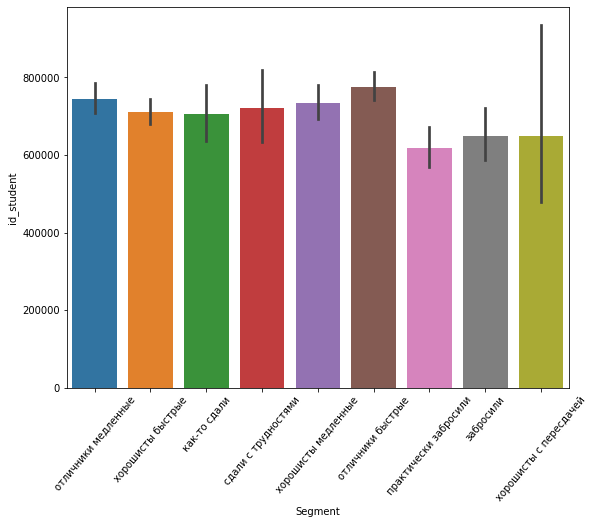

In [58]:
plt.figure(figsize=(9, 7))
plt.xticks(rotation=50)
sns.barplot(data=exams_rfm, x="Segment", y="id_student")

# Интерпретация результатов RFM кластеров 

К счастью для нас, наш ТОП-3 сегментов состоит только из хорошистов и отличников. Причём, большая часть студентов справляется довольно быстро со своими задачами. И это хорошо, так как косвенно свидетельствует о том, что материал понятный и поддержка обучающихся работает хорошо.


К сожалению, есть довольно большая группа тех, кто практически забросил курс, поэтому можно побольше поработать над ретеншеном, чтобы люди меньше бросали, а потом не возвращались. Самой немногочисленной группой стали хорошисты с пересдачей.